# Xarray + Cloud OISST (One-Month) Basics & Stats

This notebook demonstrates basic **xarray** operations on a **one-month** subset of a cloud-hosted climate dataset: **NOAA OISST v2.1 daily SST** on AWS Public Datasets (NetCDF files). You'll:
- Discover files for one month on S3 with `fsspec`
- Open them with `xarray.open_mfdataset` (anonymous S3)
- Inspect dataset structure
- Subset in space (and within that month)
- Compute basic stats (mean, std, anomalies relative to the month’s mean)
- Make maps of the month-mean and variability

**Deliverables:** Answer the **🧩 Questions** in the markdown prompts. Fill in the code where indicated by `# TODO`.


In [1]:
import xarray as xr
import fsspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120


## 1) Open the cloud dataset (NetCDF on AWS, one month)

We'll access **NOAA OISST v2.1 (daily)** in the NOAA CDR bucket on AWS. Files are arranged by **YYYYMM**.

**🧩 Questions**
1. What engine are we using to read NetCDF files from S3? 
- h5netcdf
2. Why do we need `storage_options={'anon': True}`? 
- Because we don't need AWS credintials because the data is free and open to use
3. Inspect dataset attributes: what are the units and long name of `sst`? 
- Daily sea surface temperature, and Celsius


In [8]:
yearmonth = "202001"  # TODO: try other months like "201507" or "201909"
prefix = f"noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/{yearmonth}/oisst-avhrr-v02r01.*.nc"

fs = fsspec.filesystem("s3", anon=True)
paths = sorted(fs.glob(prefix))
print(f"Found {len(paths)} files for {yearmonth}. Example:", paths[:2])

urls = [f"s3://{p}" for p in paths]

ds = xr.open_mfdataset(
    urls,
    engine="h5netcdf",
    combine="by_coords",
    decode_times=True,
    mask_and_scale=True,
    backend_kwargs={"storage_options": {"anon": True}},
    chunks={"time": 1}
)

ds


Found 31 files for 202001. Example: ['noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202001/oisst-avhrr-v02r01.20200101.nc', 'noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202001/oisst-avhrr-v02r01.20200102.nc']


<xarray.Dataset> Size: 514MB
Dimensions:  (time: 31, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2020-01-31T12...
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * zlev     (zlev) float32 4B 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 129MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    naming_authority:           gov.noaa.ncei
    cdm_data_type:              Grid
    date_modified:              2020-02-11T16:01:00Z
    date_created:               2020-02-11T16:01:00Z
    processing_level:           NOAA Level 4
    ...                         ...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    product_version:            Version v02r01
    platform:                   Ships, buoys, Argo floats, MetOp-A, MetOp-B
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    id:                         oisst-avhrr-v02r01.20200101.nc

## 2) Explore coordinates & variables

**🧩 Questions**
1. What are the coordinate names for time and space? Time: time, Space: lat, lon, zlev
2. What is the shape of `sst`? - (31, 1, 720, 1440)
3. How are missing values represented? - NaN


In [12]:
list(ds.data_vars), list(ds.coords)

(['anom', 'err', 'ice', 'sst'], ['time', 'lat', 'lon', 'zlev'])

## 3) Time & space subsetting

We'll select a **regional box** (e.g., Gulf of Mexico) within this month.

**🧩 Questions**
1. What lon/lat bounds did you choose? - lon_min, lon_max = -70, -60 and
lat_min, lat_max =  20,  30
2. How many daily steps are present in this month? - 31


In [15]:
var = "sst"

lon_min, lon_max = -70, -60   # TODO
lat_min, lat_max =  20,  30   # TODO

def to_0360(lon):
    lon = np.asarray(lon)
    out = np.mod(lon, 360.0)
    out[out < 0] += 360.0
    return out

lon_min_0360, lon_max_0360 = to_0360([lon_min, lon_max])

dss = ds.sel(
    lon=slice(lon_min_0360, lon_max_0360),
    lat=slice(lat_min, lat_max)
)

dss[var]


<xarray.DataArray 'sst' (time: 31, zlev: 1, lat: 40, lon: 40)> Size: 198kB
dask.array<getitem, shape=(31, 1, 40, 40), dtype=float32, chunksize=(1, 1, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2020-01-31T12...
  * lat      (lat) float32 160B 20.12 20.38 20.62 20.88 ... 29.38 29.62 29.88
  * lon      (lon) float32 160B 290.1 290.4 290.6 290.9 ... 299.4 299.6 299.9
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    valid_min:  -300
    valid_max:  4500
    units:      Celsius

## 4) Basic statistics

Compute region-wide stats through time and over space **within this month**.

**🧩 Questions**
1. Compute the spatial mean SST time series over your box. What is the monthly average and standard deviation?
- Month mean SST (°C): 24.772123336791992
- Month std SST (°C): 0.34616854786872864
2. Compute within-month anomalies (subtract the month-mean). What are the largest positive and negative anomalies?
- Max anomaly (°C): 0.6712120771408081
- Min anomaly (°C): -0.411581605672836
3. What day had the warmest/coolest region-mean SST?
- Warmest day: 2020-01-02 25.443336486816406
- Coolest day: 2020-01-24 24.3605422973632


Month mean SST (°C): 24.772123336791992
Month std SST (°C): 0.34616854786872864


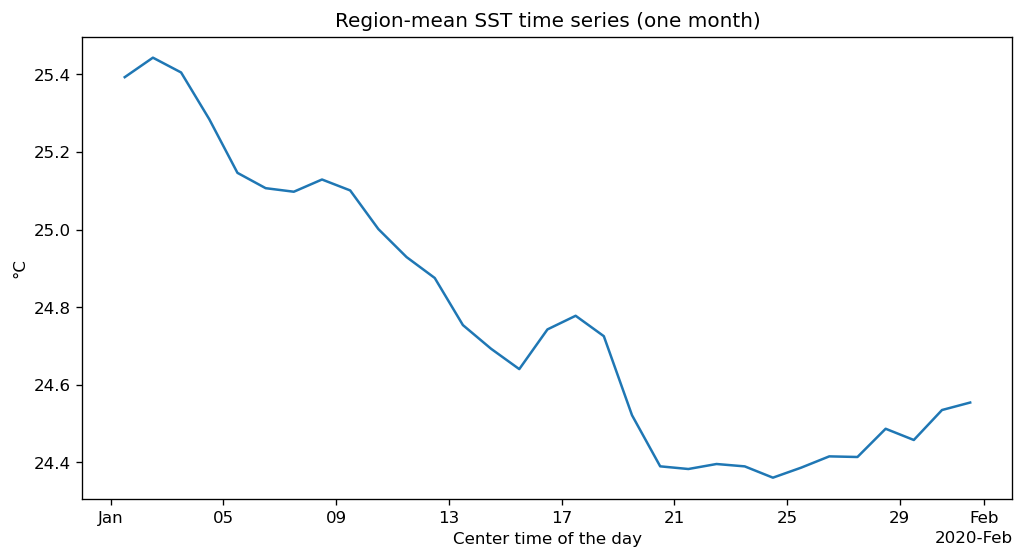

Warmest day: 2020-01-02 25.443336486816406
Coolest day: 2020-01-24 24.36054229736328


C:\Users\tnaut\AppData\Local\Temp\ipykernel_14440\4235597154.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
C:\Users\tnaut\AppData\Local\Temp\ipykernel_14440\4235597154.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


In [16]:
ts = dss[var].mean(dim=['lat','lon'])

ts_mean = ts.mean().compute()
ts_std  = ts.std().compute()
print('Month mean SST (°C):', float(ts_mean.values))
print('Month std SST (°C):', float(ts_std.values))

ts.load().plot()
plt.title('Region-mean SST time series (one month)')
plt.ylabel('°C')
plt.show()

imax = int(ts.argmax('time'))
imin = int(ts.argmin('time'))
print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


Max anomaly (°C): 0.6712120771408081
Min anomaly (°C): -0.4115816056728363


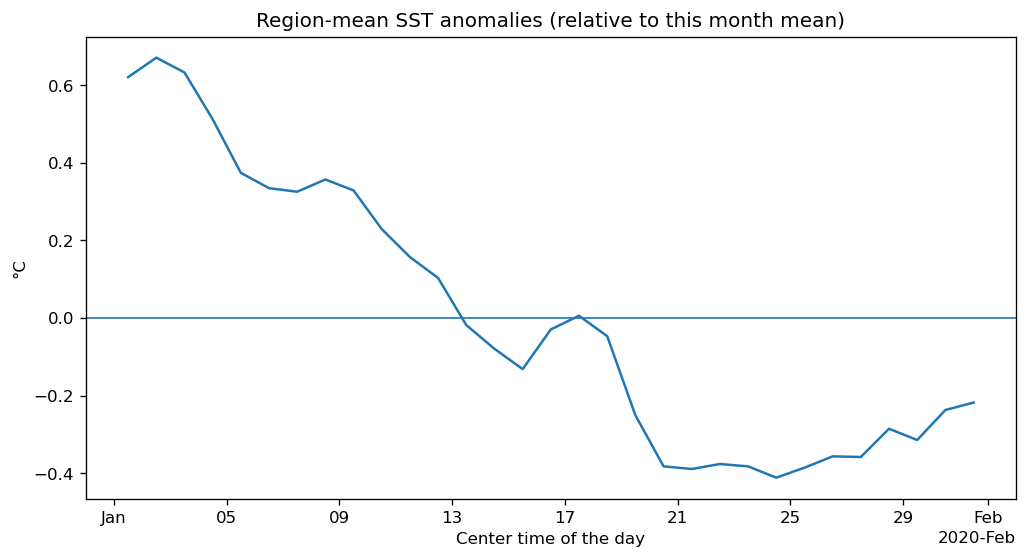

In [17]:
month_mean = dss[var].mean('time')
anom = dss[var] - month_mean

ts_anom = anom.mean(dim=['lat','lon'])
print('Max anomaly (°C):', float(ts_anom.max().compute().values))
print('Min anomaly (°C):', float(ts_anom.min().compute().values))

ts_anom.load().plot()
plt.title('Region-mean SST anomalies (relative to this month mean)')
plt.axhline(0, lw=1)
plt.ylabel('°C')
plt.show()


## 5) Regional maps: month-mean and variability

Make maps of month-mean SST and within-month variability (std and range).

**🧩 Questions**

### 1. What patterns do you notice?
#### Month-mean SST (left panel):
Clear north/south gradient: warmer waters to the south, cooler to the north (consistent with latitude and winter season). Values range roughly from 27°C in the south to ~21–22°C in the north.

#### Std Dev (middle panel):
Most of the region shows relatively low variability (<0.4°C). A few localized “hotspots” with stronger fluctuations, showing up as bright yellow patches (0.8–1.0°C).

#### Range (right panel):
Mirrors the std dev: variability patches appear in the same areas. Range can exceed 2–3°C in some localized spots, suggesting transient cooling/warming events during the month.

### 2. Where is variability strongest?
Variability (both std dev and range) is strongest in localized northern parts of the box, especially around 26–28°N, 295–296°E. This likely corresponds to fronts or eddies, where currents and mixing produce more short-term SST fluctuations. The southern portion of the box (warmer waters) is comparatively stable, with low variability.


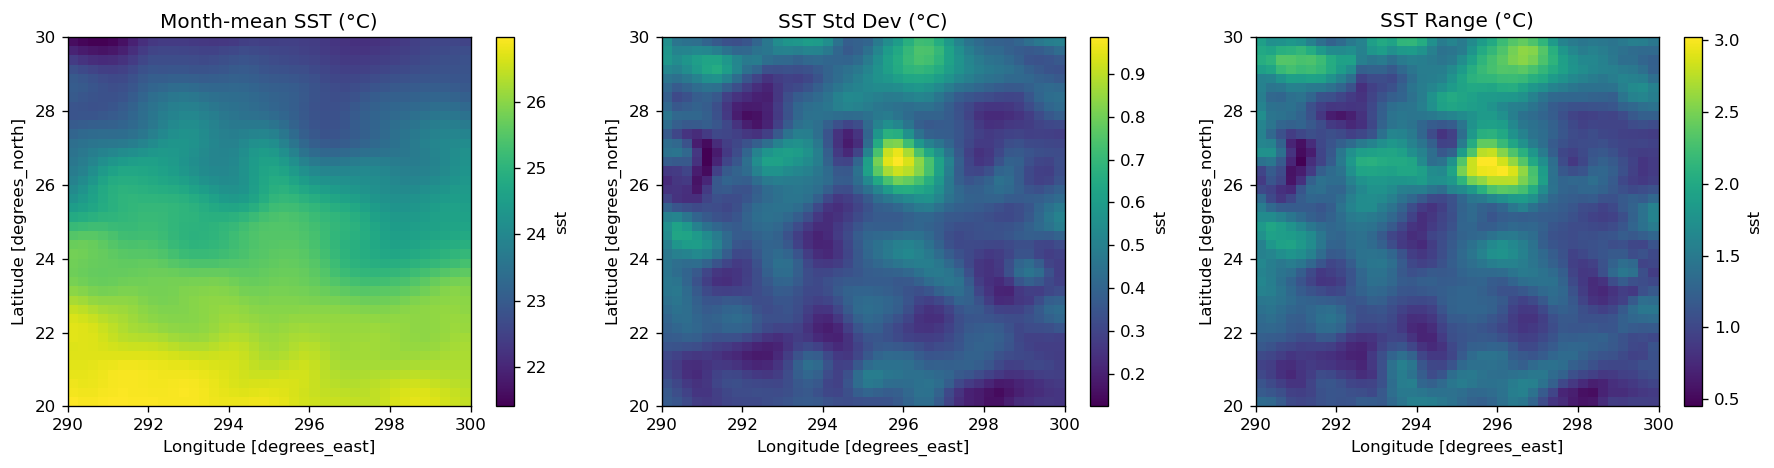

In [18]:
mean_sst = dss[var].mean('time')
std_sst  = dss[var].std('time')
range_sst = dss[var].max('time') - dss[var].min('time')

fig = plt.figure(figsize=(15,4))
ax = plt.subplot(1,3,1); mean_sst.plot(ax=ax); ax.set_title('Month-mean SST (°C)')
ax = plt.subplot(1,3,2); std_sst.plot(ax=ax); ax.set_title('SST Std Dev (°C)')
ax = plt.subplot(1,3,3); range_sst.plot(ax=ax); ax.set_title('SST Range (°C)')
plt.tight_layout(); plt.show()


## 6) Export a small subset for sharing (Check In Problem for Module 2)

Write a NetCDF with your regional mean time series and month-mean/variability maps.  Upload with your committed repository.

In [19]:
import os
import xarray as xr

ts_region = dss[var].mean(["lat", "lon"], skipna=True)
if "zlev" in ts_region.dims:
    ts_region = ts_region.squeeze("zlev", drop=True)

mean_sst = dss[var].mean("time", skipna=True)
std_sst = dss[var].std("time", skipna=True)
range_sst = dss[var].max("time", skipna=True) - dss[var].min("time", skipna=True)

if "zlev" in mean_sst.dims:
    mean_sst = mean_sst.squeeze("zlev", drop=True)
if "zlev" in std_sst.dims:
    std_sst = std_sst.squeeze("zlev", drop=True)
if "zlev" in range_sst.dims:
    range_sst = range_sst.squeeze("zlev", drop=True)

out = xr.Dataset(
    data_vars=dict(
        sst_region_mean=(
            ("time",),
            ts_region.astype("float32").data,
            {"long_name": "Region-mean SST", "units": "degree_Celsius"},
        ),
        sst_month_mean=(
            ("lat", "lon"),
            mean_sst.astype("float32").data,
            {"long_name": "Month-mean SST", "units": "degree_Celsius"},
        ),
        sst_month_std=(
            ("lat", "lon"),
            std_sst.astype("float32").data,
            {"long_name": "Within-month SST standard deviation",
             "units": "degree_Celsius"},
        ),
        sst_month_range=(
            ("lat", "lon"),
            range_sst.astype("float32").data,
            {"long_name": "Within-month SST range (max - min)",
             "units": "degree_Celsius"},
        ),
    ),
    coords=dict(
        time=ts_region["time"],
        lat=dss["lat"],
        lon=dss["lon"],
    ),
    attrs=dict(
        title="OISST v2.1 regional subset (monthly summary)",
        source="NOAA OISST v2.1 (AWS NOAA CDR bucket); opened via xarray/fsspec",
        yearmonth=yearmonth,
        region_box=(
            f"lon[{float(dss.lon.min()):.2f},{float(dss.lon.max()):.2f}], "
            f"lat[{float(dss.lat.min()):.2f},{float(dss.lat.max()):.2f}]"
        ),
        history="Created by Autumn Bolhuis; generated with xarray.to_netcdf",
        conventions="CF-1.8 (approx)",
    ),
)

encoding = {name: {"zlib": True, "complevel": 4} for name in out.data_vars}
encoding.update({"lat": {"zlib": True}, "lon": {"zlib": True}})

os.makedirs("outputs", exist_ok=True)
outfile = f"outputs/oisst_subset_{yearmonth}.nc"
out.to_netcdf(outfile, format="NETCDF4", encoding=encoding)

print("Wrote:", outfile)
out

Wrote: outputs/oisst_subset_202001.nc


<xarray.Dataset> Size: 20kB
Dimensions:          (time: 31, lat: 40, lon: 40)
Coordinates:
  * time             (time) datetime64[ns] 248B 2020-01-01T12:00:00 ... 2020-...
  * lat              (lat) float32 160B 20.12 20.38 20.62 ... 29.38 29.62 29.88
  * lon              (lon) float32 160B 290.1 290.4 290.6 ... 299.4 299.6 299.9
Data variables:
    sst_region_mean  (time) float32 124B dask.array<chunksize=(1,), meta=np.ndarray>
    sst_month_mean   (lat, lon) float32 6kB dask.array<chunksize=(40, 40), meta=np.ndarray>
    sst_month_std    (lat, lon) float32 6kB dask.array<chunksize=(40, 40), meta=np.ndarray>
    sst_month_range  (lat, lon) float32 6kB dask.array<chunksize=(40, 40), meta=np.ndarray>
Attributes:
    title:        OISST v2.1 regional subset (monthly summary)
    source:       NOAA OISST v2.1 (AWS NOAA CDR bucket); opened via xarray/fs...
    yearmonth:    202001
    region_box:   lon[290.12,299.88], lat[20.12,29.88]
    history:      Created by Autumn Bolhuis; generated with xarray.to_netcdf
    conventions:  CF-1.8 (approx)